In [49]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt

In [50]:
class Agent():
    def __init__(self, obs_dim, act_dim, hidden_dim=32, lr=0.001):

        self.logits = nn.Sequential(nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim)
            )

        self.logits_optimizer = optim.Adam(self.logits.parameters(), lr=lr)

    def get_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32)
        policy = torch.distributions.Categorical(logits=self.logits(obs))
        return policy.sample().item()

    def get_rewards_to_go(self, rewards):
        n = len(rewards)
        rtgs = np.zeros_like(rewards)
        for i in reversed(range(n)):
            rtgs[i] = rewards[i] + (rtgs[i+1] if i+1 < n else 0)
        return list(rtgs)

    def get_logits_loss(self, obs, acts, rtgs):
        policy = torch.distributions.Categorical(logits=self.logits(obs))
        log_probs = policy.log_prob(acts)
        return -(log_probs*rtgs).mean()        

In [51]:
def train(env, agent, epochs=100, batch_size=100):
    scores = []
    avg_scores = []
    for e in range(epochs):
        batch_obs = []
        batch_acts = []
        batch_rtgs = []
        while True:
            ep_rewards = []
            ep_len = 0
            obs = env.reset()
            done = False
            while not done:
                act = agent.get_action(obs)
                obs_, r, done, _ = env.step(act)

                batch_obs.append(obs)
                batch_acts.append(act)
                ep_rewards.append(r)

                obs = obs_
                ep_len += 1

            scores.append(ep_len)
            batch_rtgs += agent.get_rewards_to_go(ep_rewards)

            if len(batch_obs) >= batch_size:
                break

        batch_obs = torch.tensor(batch_obs, dtype=torch.float32)
        batch_acts = torch.tensor(batch_acts, dtype=torch.float32)
        batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float32)

        agent.logits_optimizer.zero_grad()
        batch_loss = agent.get_logits_loss(batch_obs, batch_acts, batch_rtgs)
        batch_loss.backward()
        agent.logits_optimizer.step()

        avg_score = sum(scores[-10:])/len(scores[-10:])
        avg_scores.append(avg_score)

        if (e+1) % 100 == 0:
            print('Epoch: %3d \t avg_score: %.3f'% (e+1, avg_score))

    env.close()
    return avg_scores

In [52]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
print("Obs_dim:", obs_dim)
print("Act dim:", act_dim)

Obs_dim: 4
Act dim: 2


In [53]:
agent = Agent(obs_dim, act_dim)

In [54]:
avg_scores = train(env, agent, epochs=1000)

Epoch:  99 	 avg_score: 43.300
Epoch: 199 	 avg_score: 95.600
Epoch: 299 	 avg_score: 161.800
Epoch: 399 	 avg_score: 232.700
Epoch: 499 	 avg_score: 234.300
Epoch: 599 	 avg_score: 300.700
Epoch: 699 	 avg_score: 299.000
Epoch: 799 	 avg_score: 473.000
Epoch: 899 	 avg_score: 440.500
Epoch: 999 	 avg_score: 432.200


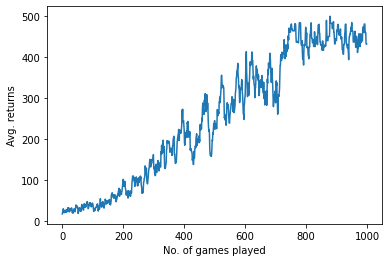

done


In [55]:
plt.plot(np.arange(0,len(avg_scores)), avg_scores)
plt.xlabel('No. of games played')
plt.ylabel('Avg. returns')
plt.show()
print('done')